In [1]:
###### -*- coding: utf-8 -*-
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from pandas import Series, DataFrame
import matplotlib.cm as cm
from math import *
import collections
import seaborn as sns
import time
import random
import itertools
import networkx as nx
import collections
mylen = np.vectorize(len)

In [2]:
######Initial state: X number of randomly selected distinct sequences.
def initial6(L, N, Char, X):
    population = [''.join(np.random.choice(Char, L, replace=True)) for i in range(X)]
    population = population*int(N/X)
    np.random.shuffle(population) 
    return population

#####Analyze closed networks
def time_limited_cycles(G, time_limit=2.0):
    elapsed, cycle_generator = 0.0, nx.simple_cycles(G)
    while elapsed <= time_limit:
        start_time = time.time()
        try:
            cycle = next(cycle_generator)
        except StopIteration:
            break
        yield cycle
        elapsed += time.time() - start_time 

##### Sample all the indexes when a particular string matches in another string.
def find_all(st, substr, start_pos=0, accum=[]):
    ix = st.find(substr, start_pos)
    if ix == -1: #no match
        return accum
    else:
        return find_all(st, substr, start_pos=ix + 1, accum=accum + [ix])

In [5]:
#####Recombination 
def recombination(S,N): #S, required base-pairs; N, population size
    global recombi_num 
    idx = random.sample(range(N),3) #randamly choose a template and two substrates (monomers)
    template = population[idx[0]]
    monomer1 = population[idx[1]]
    monomer2 = population[idx[2]]
    #make a complementary strand (just for analysis)
    rev_template = template[::-1]
    rev_template = rev_template.translate(str.maketrans('AUGC', 'UACG')) 

    ##Recombination: AC + B + template -> AB + C 
    #assuming that monomer1 is B and monomer 2 is AC
    if len(monomer1)>=S and len(monomer2)>=S:
        comp1_set = find_all(rev_template, monomer1[:S]) #fold with monomer 1 (various possibilities)         
        if len(comp1_set) >= 1:
            comp1 = random.choice(comp1_set) #choose one
            comp2_set = find_all(monomer2[:-1], rev_template[comp1-S:comp1])#monomer2のS塩基に一致する場所をすべて抽出                
            if comp1 >= S and len(comp2_set) >= 1:#fold with monomer 2 (various possibilities)
                comp2 = random.choice(comp2_set) #choose one
                ##recombination reaction: 
                new_monomer1 = monomer2[:comp2+S] + monomer1
                new_monomer2 = monomer2[comp2+S:]
                #replace the original monomers (the template is not changed)
                population[idx[1]] = new_monomer1
                if len(new_monomer2)>2:
                    population[idx[2]] = new_monomer2
                else: 
                    population[idx[2]] = np.random.choice(initial_population) #replace if too short to react
                recombi_num +=1
                catalysts.append(template)
                products.append(new_monomer1)
                product2s.append(new_monomer2)
                monomer1s.append(monomer1)
                monomer2s.append(monomer2)

        else:#assuming that monomer 1 is AC and monomer 2 is B
            comp3_set = find_all(rev_template, monomer2[:S])
            if len(comp3_set) >= 1:
                comp3 = random.choice(comp3_set)        
                comp4_set = find_all(monomer1[:-1], rev_template[comp3-S:comp3])              
                if comp3 >= S and len(comp4_set) >= 1:
                    comp4 = random.choice(comp4_set)
                    new_monomer1 = monomer1[:comp4+S] + monomer2
                    new_monomer2 = monomer1[comp4+S:]
                    population[idx[1]] = new_monomer1
                    if len(new_monomer2)>2:
                        population[idx[2]] = new_monomer2
                    else: 
                        population[idx[2]] = np.random.choice(initial_population)
                    recombi_num +=1
                    catalysts.append(template)
                    products.append(new_monomer1)
                    product2s.append(new_monomer2)
                    monomer1s.append(monomer1)
                    monomer2s.append(monomer2)

#####calculate complexity of a graph
def complexity(thr, catalysts, products, recombi_num, final_population):
    G = nx.DiGraph()
    G.add_nodes_from(catalysts)
    G.add_nodes_from(products)
    edges = [(catalysts[i],products[i]) for i in range(recombi_num)]
    
    #weight: how many times each catalytic reaction occurred.
    for node0,node1 in edges:
        if G.has_edge(node0, node1):
                G[node0][node1]["weight"] += 1
        else:
            G.add_edge(node0, node1, weight = 1)

    #remove edges depending on "weight" threashold
    for (u,v,d) in list(G.edges(data=True)): #need 'list' otherwise, error appears (dictionary size changes)
        if d['weight'] < thr:
            G.remove_edge(u, v)

    #remove nodes that dose not exist in the final population
    node_set = list(G.nodes())
    non_exist_nodes = list(set(node_set) - set(final_population))
    G.remove_nodes_from(non_exist_nodes)

    #explore closed cycles (or self-reproduction) (permit overlap at this point)
    global cycle_num
    cycle_edges = []
    closed_cycles_or_self = list(time_limited_cycles(G)) #only above threshold, including self-reproduction
    #cycle_num = len(closed_cycles_or_self)
    cycle_size = []
    for i in range(len(closed_cycles_or_self)):
        a = [(closed_cycles_or_self[i][j], closed_cycles_or_self[i][j+1])\
                             for j in range(len(closed_cycles_or_self[i])-1)]
        a = a + [(closed_cycles_or_self[i][-1], closed_cycles_or_self[i][0])]
        for k in range(len(a)):
            cycle_size.append(len(a))
        cycle_edges += a
    
    #calclate maximum cycle size
    global maxsize
    if len(cycle_size)>0:
        maxsize = max(cycle_size) 

    #Acquire information of weight for each edge
    cycle_weights = [G[cycle_edges[i][0]][cycle_edges[i][1]]['weight'] for i in range(len(cycle_edges))]

    #Make new graph by eliminating overlap of edges(to make each highest order remain)
    newG = nx.DiGraph()
    for i in range(len(cycle_edges)):
        node0, node1 = cycle_edges[i][0], cycle_edges[i][1]
        if newG.has_edge(node0, node1) and newG[node0][node1]["cycle_size"] < cycle_size[i]:
            newG.add_edge(node0,node1, cycle_size = cycle_size[i], weight= cycle_weights[i])
        elif newG.has_edge(node0, node1):       
            pass
        else:
            newG.add_edge(node0,node1, cycle_size = cycle_size[i], weight= cycle_weights[i])

    #calculate fraction of networks
    global fraction
    if len(edges)>0:
        new_weights = [newG[list(newG.edges())[i][0]][list(newG.edges())[i][1]]['weight'] \
                    for i in range(len(newG.edges()))]
        fraction = sum(new_weights)/len(edges)
    G.clear()

In [11]:
#####Initial condition
L = 8 # length of initial population
S = 3 # requied complementary consecutive nucletides (for each side) for recombination
Char =['A', 'U','G','C']

#####Run
Xset = [2,5,10,20,40,80,160]
thr = 2 #T: threshold of "weight" (how many times each catalytic reaction need to occur)
for l in range(len(Xset)):
    recombi_num_set, reaction_variation_set, maxsize_set, fraction_set  = [],[],[],[]
    X = Xset[l]
    N = 300*X #population size
    genmax = 30000*X #reaction step
    for k in range(100):
        gen=0
        recombi_num, maxsize, fraction = 0,0,0
        gen_set = []
        catalysts = []
        products, product2s, = [],[] #product: ligated, 2: cleaved
        monomer1s, monomer2s = [],[],
        population = initial6(L, N, Char, X)
        initial_population = list(set(population))
        print(initial_population[:5])

        #Recombination
        start = time.perf_counter()
        for i in range(genmax):
            recombination(S,N) 
        final_population = population
        recombi_num_set.append(recombi_num)
        #calculate reaction variation
        reactions = [[catalysts[i],products[i]] for i in range(len(catalysts))]
        reactions_unique = list(map(list, set(map(tuple, reactions)))) #remove duplicated elements
        reaction_variation = len(reactions_unique)
        reaction_variation_set.append(reaction_variation)
        end = time.perf_counter()
        print('run time', end-start, 'sec')

        #####Calculation of complexity
        start = time.perf_counter()
        complexity(thr, catalysts, products, recombi_num, final_population)
        maxsize_set.append(maxsize)
        fraction_set.append(fraction)
        end = time.perf_counter()
        print('calculation time', end-start, 'sec')
        print('##########')

    ######DataFrame
    df = DataFrame({'recombi_num' : recombi_num_set,'reaction_variation' :reaction_variation_set,\
                    'maxsize':maxsize_set,'fraction':fraction_set}, \
                    columns = ['recombi_num','reaction_variation','maxsize','fraction'])
    df.to_csv('Recombination_'+'X_X='+str(X)+'_S='+str(S)+'_T='+str(thr)+\
              '_gen='+str(genmax)+'.csv')
    #df.to_csv('NNNNNNNN_T='+str(thr)+'_gen='+str(genmax)+'.csv')
    print('Done')
df

['GCAAGAGC', 'CUUUUUCA', 'CAUAUCUG', 'UGCGCCGC', 'AGCACGUA']
run time 4.386767064999987 sec
calculation time 0.04962132099998939 sec
##########
Done


,recombi_num,reaction_variation,maxsize,fraction
0,4461,2596,11,0.108496


[['AUUUCGAAACGAUG', 'CCAGUUUCGACAUG'], ['GGUAUGCAUACA', 'ACGCGUAUGCAUACA'], ['CCAGUUCUAGAUAAC', 'GGCUAGAA'], ['GGCUAGAA', 'AUUUCUAGAUAAC'], ['CAGGGACC', 'UCAGGGUCCCUUCUAGAUAAC', 'CAGGGACCCUUCUC', 'UCAGGGUCCCUUCUC'], ['CAGGGACC', 'UCAGGGUCCCUUCUC'], ['UCAGGGUCCCUUCUC', 'CAGGGACCCUUCUC'], ['AUGUCGACAUG', 'GGUAUGUCGACAUG'], ['AUGUCGACAUG', 'GGUAUGUCGACAUG', 'AUUUCGACAU'], ['AUGUCGACAUG', 'ACGCGUAUGUCGACAUG'], ['AUGUCGACAUG', 'AUUUCGACAU'], ['GGCUAUAGAUAAC', 'AUCUAUAG', 'CCAGUUCUAUAGAUAAC'], ['GGCUAUAGAUAAC', 'AUCUAUAG', 'CCCUUCUAUAGAUAAC', 'GUGCUAUAGAUAAC'], ['GGCUAUAGAUAAC', 'AUCUAUAG', 'CCCUUCUAUAGAUAAC', 'GUGCUAUAGAUAAC', 'CCAGUUCUAUAGAUAAC'], ['GGCUAUAGAUAAC', 'AUCUAUAG', 'CCCUUCUAUAGAUAAC', 'GUGCUAUAGAUAAC', 'CCAGUUAUCUAUAG'], ['GGCUAUAGAUAAC', 'AUCUAUAG', 'CCCUUCUAUAGAUAAC', 'GUGCUAUAGAUAAC', 'CCAGUUAUCUAUAG', 'AUCUAUAGAUAAC'], ['GGCUAUAGAUAAC', 'AUCUAUAG', 'CCCUUCUAUAGAUAAC', 'CCAGUUAUCUAUAG'], ['GGCUAUAGAUAAC', 'AUCUAUAG', 'CCCUUCUAUAGAUAAC', 'CCAGUUAUCUAUAG', 'GUGCUAUAGAUAAC'], [

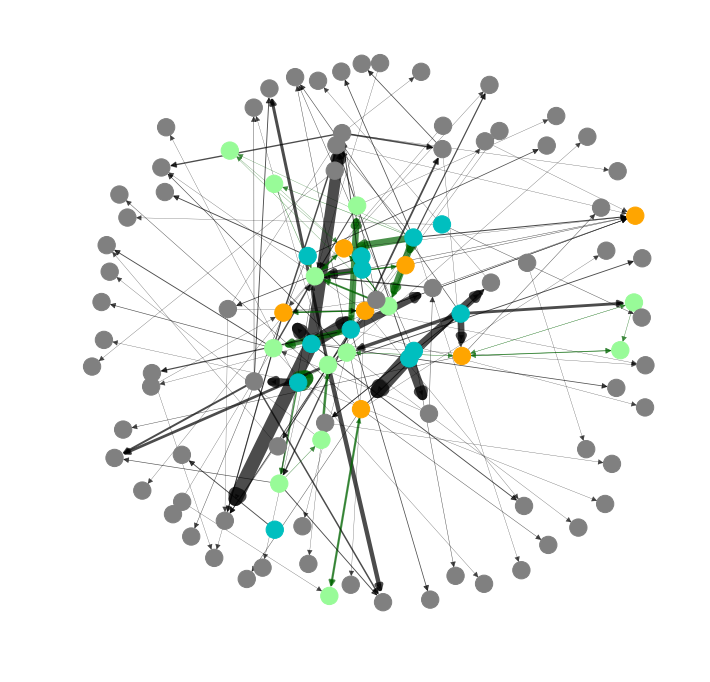

In [7]:
##### Draw a network
sns.set_style('white')
thr = 2 #threshold of "weight" (how many times each catalytic reaction occurred)

fig = plt.figure(figsize = (12,12))
G = nx.DiGraph()
G.add_nodes_from(catalysts)
G.add_nodes_from(products)
edges = [(catalysts[i],products[i]) for i in range(recombi_num)]

#weight: how many times each catalytic reaction occurred.
for node0,node1 in edges:
    if G.has_edge(node0, node1):
            G[node0][node1]["weight"] += 1
    else:
        G.add_edge(node0, node1, weight = 1)

#remove edges depending on "weight" threashold
for (u,v,d) in list(G.edges(data=True)): #need 'list' otherwise, error appears (dictionary size changes)
    if d['weight'] < thr:
        G.remove_edge(u, v)

self_reproducers = [node0 for node0, node1 in G.edges() if node0==node1]
#remove food molecules
#G.remove_nodes_from(initial_population)

#remove nodes that dose not exist in the final population
node_set = list(G.nodes())
non_exist_nodes = list(set(node_set) - set(final_population))
G.remove_nodes_from(non_exist_nodes)

#remove nodes that does not have any edges or cannot self-reproduce
node_set = list(G.nodes())
edge_set = [list(G.edges())[i][0] for i in range(len(list(G.edges())))]+\
                [list(G.edges())[i][1] for i in range(len(list(G.edges())))]
disconnected_nodes = list(set(node_set) - set(edge_set)) #detail: ask google
G.remove_nodes_from(disconnected_nodes)   

#explore closed cycles
cycle_edges = []
closed_cycles_or_self = list(time_limited_cycles(G)) #only above threshold, including self-reproduction
closed_cycles = [closed_cycles_or_self[i] for i in range(len(closed_cycles_or_self))\
                         if len(closed_cycles_or_self[i])!=1] #remove self-reproduction
for i in range(len(closed_cycles)):
    a = [(closed_cycles[i][j], closed_cycles[i][j+1]) for j in range(len(closed_cycles[i])-1)]
    a = a + [(closed_cycles[i][-1], closed_cycles[i][0])]
    cycle_edges += a

print(closed_cycles)
#print(cycle_edges)

#####drawing parameters
#widen edges depending on "weight"
edge_width = [d["weight"]*0.15 for (u,v,d) in G.edges(data=True)]  

#highlight food molecules (initial sequence set), self-reproducers, and higher order molecules
node_colors = [] 
closed_cycles_1d = list(itertools.chain(*closed_cycles)) #convert to 1D list
for node in G: 
    if node in initial_population:
        node_colors.append('c') #food molecule
    elif node in self_reproducers:
        node_colors.append('orange') #★for now, showing even if self-reprocution is below threshold
    elif node in closed_cycles_1d:
        node_colors.append('palegreen')
    else: 
        node_colors.append('gray') 

#highlight closed edges
edge_colors = []
for edge in G.edges():
    if edge in cycle_edges:
        edge_colors.append('darkgreen')
    else: 
        edge_colors.append('black')
        
#layout
pos = nx.spring_layout(G, k=0.8) #k: Optimal distance between nodes
#pos = nx.shell_layout(G)

#####draw
# nx.draw_networkx(G,pos,node_color = color_map,with_labels = True, \
#                 width = edge_width, edge_color="black")
nx.draw_networkx_nodes(G, pos, node_color=node_colors)
#nx.draw_networkx_labels(G, pos)
edges_draw = nx.draw_networkx_edges(G, pos, width= edge_width, alpha = 0.7, \
                               arrowsize=12, edge_color=edge_colors) #edge_color=edge_width, edge_cmap=plt.cm.seismic

#Change alpha dependign on "weight"
# for i in range(G.number_of_edges()):
#     if edge_width[i]>1:
#         edge_width[i] = 1
#     edges_draw[i].set_alpha(edge_width[i])

plt.axis('off')
plt.show()
fig.savefig("graph", dpi=1000, transparent=False)

6
0.2631578947368421
1686


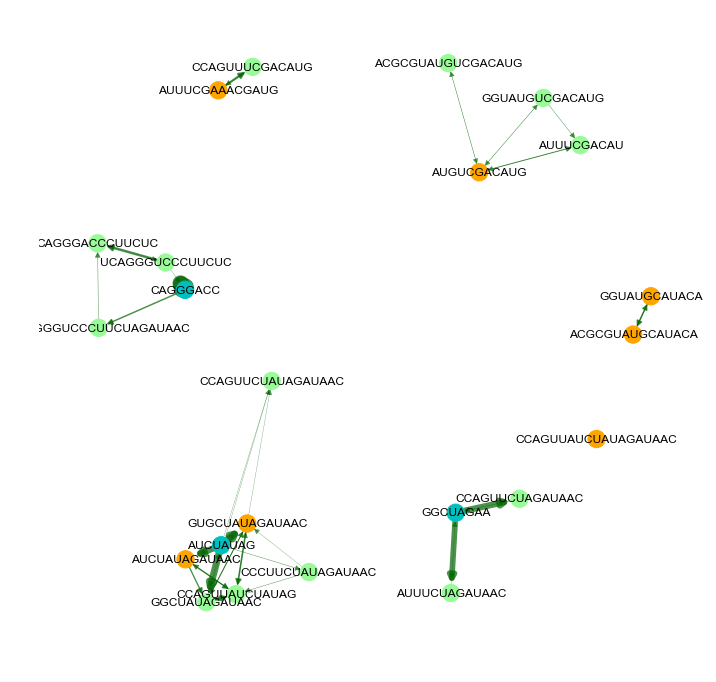

In [8]:
#Draw reproduction networks
thr = 2 #threshold of "weight" (how many times each catalytic reaction occurred)

G = nx.DiGraph()
G.add_nodes_from(catalysts)
G.add_nodes_from(products)
edges = [(catalysts[i],products[i]) for i in range(recombi_num)]

#weight: how many times each catalytic reaction occurred.
for node0,node1 in edges:
    if G.has_edge(node0, node1):
            G[node0][node1]["weight"] += 1
    else:
        G.add_edge(node0, node1, weight = 1)

#remove edges depending on "weight" threashold
for (u,v,d) in list(G.edges(data=True)): #need 'list' otherwise, error appears (dictionary size changes)
    if d['weight'] < thr:
        G.remove_edge(u, v)

self_reproducers = [node0 for node0, node1 in G.edges() if node0==node1]

#remove nodes that dose not exist in the final population or catalysts
node_set = list(G.nodes())
non_exist_nodes = list(set(node_set) - set(final_population))
G.remove_nodes_from(non_exist_nodes)

#remove nodes that does not exist in "catalysts"
node_set = list(G.nodes())
non_exist_nodes = list(set(node_set) - set(catalysts))
G.remove_nodes_from(non_exist_nodes)

#explore closed cycles (or self-reproduction) (permit overlap at this point)
cycle_edges = []
#closed_cycles_or_self = list(nx.simple_cycles(G)) #only above threshold, including self-reproduction
closed_cycles_or_self = list(time_limited_cycles(G))
cycle_size = []

for i in range(len(closed_cycles_or_self)):
    a = [(closed_cycles_or_self[i][j], closed_cycles_or_self[i][j+1])\
                         for j in range(len(closed_cycles_or_self[i])-1)]
    a = a + [(closed_cycles_or_self[i][-1], closed_cycles_or_self[i][0])]
    for k in range(len(a)):
        cycle_size.append(len(a))
    cycle_edges += a

#calculate maximum network size
maxsize = 0
if len(cycle_size)>0:
    maxsize = max(cycle_size)
    print(maxsize)
    
#Acquire information of weight for each edge
cycle_weights = [G[cycle_edges[i][0]][cycle_edges[i][1]]['weight'] for i in range(len(cycle_edges))]

#Make new graph by eliminating overlap of edges(to make each highest order remain) 
#★this is slow, could be improved.
newG = nx.DiGraph()
for i in range(len(cycle_edges)):
    node0, node1 = cycle_edges[i][0], cycle_edges[i][1]
    if newG.has_edge(node0, node1) and newG[node0][node1]["cycle_size"] < cycle_size[i]:
        newG.add_edge(node0,node1, cycle_size = cycle_size[i], weight= cycle_weights[i])
    elif newG.has_edge(node0, node1):       
        pass
    else:
        newG.add_edge(node0,node1, cycle_size = cycle_size[i], weight= cycle_weights[i])

#calculate fraction of networks
if len(edges)>0:
    new_weights = [newG[list(newG.edges())[i][0]][list(newG.edges())[i][1]]['weight'] \
                for i in range(len(newG.edges()))]
    fraction = sum(new_weights)/len(edges)
    print(fraction)

#calculate index (weight of each edge X number of members for each edge)
complexity_index = 0
for (u,v,d) in list(newG.edges(data=True)):
    complexity_index += d['cycle_size']*d['weight']
print(complexity_index)


####drawing
fig = plt.figure(figsize = (12,12))
#highlight food molecules (initial sequence set), self-reproducers, and higher order molecules
node_colors = []
for node in newG: 
    if node in initial_population:
        node_colors.append('c') #food molecule
    elif node in node in self_reproducers:
        node_colors.append('orange') #self-reproducer
    else: 
        node_colors.append('palegreen') 

#widen edges depending on "weight"
edge_width = [d["weight"]*0.15 for (u,v,d) in newG.edges(data=True)]  

pos = nx.spring_layout(newG, k=0.8) #k: Optimal distance between nodes

nx.draw_networkx_nodes(newG, pos, node_color=node_colors)
nx.draw_networkx_labels(newG, pos)
edges_draw = nx.draw_networkx_edges(newG, pos, width= edge_width, alpha = 0.7, \
                               arrowsize=12, edge_color="darkgreen") #edge_color=edge_width, edge_cmap=plt.cm.seismic
plt.axis('off')
plt.show()
fig.savefig("graph2", dpi=1000, transparent=False)